In [1]:
from my_functions import *

In [2]:
%load_ext autoreload
%autoreload 2

### Data

Each molecule consists of $n$ atoms. The atoms are coded by indexes $[1, 2, \dots, n]$. A bond between an atom with index $i$ and an atom with index $j$ is set as a pair $(i, j)$.

<img src="images/complex.png" width="600">

**One protein-ligand complex generation**

`n_protein_atoms` - number of atoms in the protein

`n_ligand_atoms` - number of atoms in the ligand

`atom_feature_dim` - dimensionality of the atom feature space <font color='red'>(common argument)</font>

`max_degree` - the maximum number of bonds in which an atom can participate, common to all atoms <font color='red'>(common argument)</font>

`threshold` - if the distance between two atoms is less than this value, then there is a bond between the atoms <font color='red'>(common argument)</font>

`std`, `mu_std` - each molecula is generated by sampling $n$ atoms (points in 3D space) from a uniform distribution $U[mean-std, mean+std]$. For protein's atoms $mean = [0, 0, 0]$, for ligand's atoms $mean$ is drawned from normal distribution $\mathcal{N}(0, \mu_{std})$. <font color='red'>(common arguments)</font>

In [50]:
# common arguments
atom_feature_dim = 8
max_degree = 5
threshold = 1.8
std=1.0
mu_std=2.0

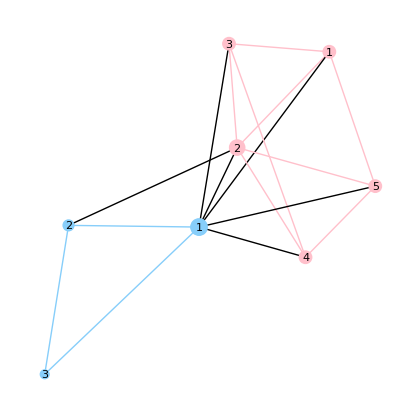

In [51]:
data = generate_complex(
    n_protein_atoms=5,
    n_ligand_atoms=3,
    atom_feature_dim=atom_feature_dim,
    max_degree=max_degree,
    threshold=threshold,
    std=std, 
    mu_std=mu_std
)
show_complex(data, 'pos')

**What's inside the data?**

As it was said earlier, each atom is defined by index $i \in [1, 2, \dots, n]$ and each bond is defined as a pair of the corresponding atoms' indexes $(i, j)$. Next chemical properties are added: each atom has a type (carbon, hydrogen, oxygen, etc.) and each bond has a type (carbon-carbon, carbon-hydrogen, hydrogen-oxygen, and so on). 

* In order to save the information about the atoms' types for each atom $i$ we will additionally store its type in the form of **embedding** $a_i$. An embedding is just a numerical representation of the categorical data.

* In order to save the information about the bonds' types we will do the same. Each bond $(i, j)$ corresponds to an embedding $b_{(i, j)}$.

<font color='red'>NB</font>: The atom and bond embeddings are predefined for all possible atom and bond types respectively.

<font color='red'>NB</font>: Identical atoms in different molecules correspond to identical embeddings. So do bonds.

Also atom have features - real vectors with lendth $d$ with extra information about the atoms.

In [52]:
data

HeteroData(
  rmsd=1.5290979146957397,
  protein={
    atoms=[5],
    x=[5, 8],
    pos=[5, 3]
  },
  ligand={
    atoms=[3],
    x=[3, 8],
    pos=[3, 3]
  },
  (protein, -, protein)={
    edge_index=[2, 8],
    edge_attr=[2]
  },
  (ligand, -, ligand)={
    edge_index=[2, 3],
    edge_attr=[2]
  },
  (protein, -, ligand)={
    edge_index=[2, 6],
    edge_attr=[2]
  }
)

For `molecule` in [`protein`, `ligand`] and `bonds` in [`protein-protein`, `ligand-ligand`, `protein-ligand`]

`molecule.atoms` - types of the atoms (embeddings) $[a_1, a_2, \dots, a_n]$

`molecule.x` - features of the atoms

`molecule.pos` - positions of the atoms in 3D space

`bonds.edge_index` - bonds in terms of [atoms_from, atoms_to] (pairs of $(i, j)$)

`bonds.edge_attr` - for each bond $(i, j)$ here are a distance between the atoms and a type of the bond $b_{(i, j)}$ (embeddings)

**Dataset**

`N` - size of the dataset

`n_protein_atoms_max` - the maximum possible number of atoms in protein

`n_ligand_atoms_number` - the maximum possible number of atoms in ligand

Plus `atom_feature_dim`, `max_degree`, `threshold`, `std`, `mu_std`

In [123]:
dataset = ProteinLigandComplexes(N=100, n_protein_atoms_max=20, n_ligand_atoms_max=10, 
                                 atom_feature_dim=atom_feature_dim, max_degree=max_degree, 
                                 threshold=threshold, std=std, mu_std=mu_std)

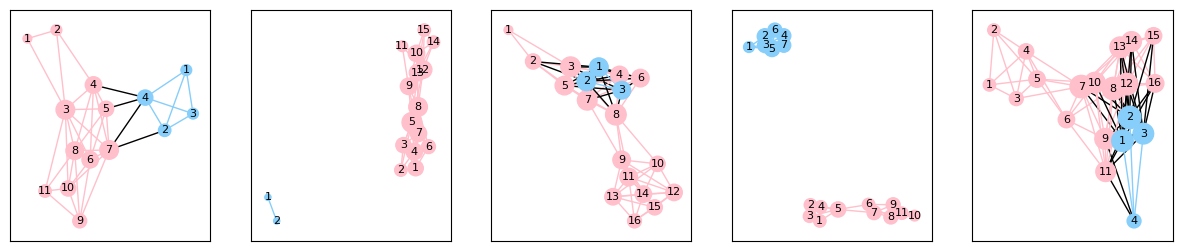

In [54]:
show_complex_batch([dataset[i] for i in range(5)], 'pos')

### Transformer-M


A molecule $\mathcal{M}$ is made up of a collection of atoms held together by attractive forces. We denote $X \in \mathbb{R}^{n \times d}$ as the atoms with features, where $n$ is the number of atoms, and $d$ is the feature dimension. The structure of $\mathcal{M}$ can be represented in different formulations, such as 2D graph structure and 3D geometric structure. For the 2D graph structure, atoms are explicitly connected by chemical bonds, and we define $\mathcal{M}^{2D} = (X, E)$, where $e(i,j) \in E$ denotes the edge feature (i.e., the type of the bond) between atom $i$ and $j$ if the edge exists. For the 3D geometric structure, for each atom $i$, its position $r_i$ in the Cartesian coordinate system is provided. We define $\mathcal{M}^{3D} = (X, R)$, where $R = \{r_1 , ..., r_n \}$ and $r_i ∈ \mathbb{R}^3$. Our goal is to design a parametric model which can take either $\mathcal{M}^{2D}$ or $\mathcal{M}^{3D}$ (or both of them) as input, obtain contextual representations, and make predictions on downstream tasks.

#### Positional Encoding 

**Encoding pair-wise relations in $E$.**
We use two terms to encode the structural relations between any atom pairs in the graph. First, we encode the shortest path distance (SPD) between two atoms to reflect their spatial relation. Let $\Phi_{ij}^{SPD}$ denote the SPD encoding between atom $i$ and $j$, which is a learnable scalar determined by the distance of the shortest path between $i$ and $j$. Second, we encode the edge features (e.g., the chemical bond types) along the shortest path between $i$ and $j$ to reflect the bond information. For most molecules, there exists only one distinct shortest path between any two atoms. Denote the edges in the shortest path from $i$ to $j$ as $SP_{ij} = (e_1, e_2, ..., e_N)$, and the edge encoding between $i$ and $j$ is defined as $$\Phi_{ij}^{Edge} = \frac{1}{N} \sum_{n=1}^N e_n(w_n)^T,$$ where $w_n$ are learnable vectors of the same dimension as the edge feature. Denote $\Phi^{SPD}$ and $\Phi^{Edge}$ as the matrix form of the SPD encoding and edge encoding, both of which are of shape $n \times n$.

**Arguments**

`n_heads` - basically encoding layers have several **heads** <font color='red'>(common argument)</font>

`n_spatial` - the maximum possible length of the shortest path

In [8]:
n_heads = 1
n_spatial = 100

<font color='red'>NB</font>: Transformer considers only one molecula, but not a complex. So here and after we will inference the model with only protein part of a complex.

In [9]:
n = len(data['protein'].atoms)

In [10]:
# Check BondEncoding2D Layer for a given data

bond_encoder_2d = BondEncoding2D(n_heads=n_heads, n_spatial=n_spatial)
phi_spd, phi_edge = bond_encoder_2d(data['protein'].atoms, data['protein', '-', 'protein'].edge_index)

assert phi_spd.shape == torch.Size([n_heads, n, n])
assert phi_edge.shape == torch.Size([n_heads, n, n])

**Encoding pair-wise relations in $R$**. 
We encode the Euclidean distance to reflect the spatial relation between any pair of atoms in the 3D space. For each atom pair $(i,j)$, we first process their Euclidean distance with the Gaussian Basis Kernel function, 
$$
\psi^k_{(i, j)} =
-\frac{1}{\sqrt{2 \pi |\sigma^k|}}
\exp{-\frac{1}{2} \left( 
    \frac{\gamma_{(i, j)} \|r_i - r_j\| + \beta_{(i, j)} - \mu^k}
    {|\sigma^k|} 
\right)^2},
$$
$k = 1, ..., K$, where $K$ is the number of Gaussian Basis kernels. Then the 3D Distance encoding $\Phi_{ij}^{3D}$ Distance is obtained according to 
$$
\Phi_{ij}^{3D} = 
\text{GELU}(\psi_{(i,j)} W_D^1) W_D^2,
$$
where $\psi_{(i,j)} = [\psi_{(i,j)}^1, ..., \psi_{(i,j)}^K]^T, W_D^1 \in \mathbb{R}^{K \times K}, W_D^2 \in \mathbb{R}^{K \times 1}$ are learnable parameters. $\gamma_{(i,j)}, \beta_{(i,j)}$ are learnable scalars indexed by the pair of atom types, and $\mu^k, \sigma^k$ are learnable kernel center and learnable scaling factor of the $k$-th Gaussian Basis Kernel. Denote $\Phi_{ij}^{3D}$ Distance as the matrix form of the 3D distance encoding, whose shape is $n \times n$.

In [11]:
# Compute an adjacency matrix filled with bond types (0 means there's no bond)
edge_types = torch.zeros(n, n).long()
atoms_from, atoms_to = data['protein', '-', 'protein'].edge_index
edge_types[atoms_from, atoms_to] = edge_types[atoms_to, atoms_from] = data['protein', '-', 'protein'].edge_attr[1]
edge_types

tensor([[ 0, 35, 47, 17,  0],
        [35,  0, 26,  0,  0],
        [47, 26,  0, 33,  0],
        [17,  0, 33,  0,  9],
        [ 0,  0,  0,  9,  0]])

**Arguments**

`n_kernels` - number of kernel functions

Plus `n_heads`

In [12]:
n_kernels = 128

In [13]:
# Check BondEncoding3D Layer for a given data

bond_encoder_3d = BondEncoding3D(n_heads=n_heads, n_kernels=n_kernels)
phi_3d, psi_3d = bond_encoder_3d(data['protein'].pos, edge_types)

assert phi_3d.shape == torch.Size([n_heads, n, n])
assert psi_3d.shape == torch.Size([n, n, n_kernels])

**Integrating $\Phi^{SPD}$, $\Phi^{Edge}$ and $\Phi^{3D}$ in Transformer-M**. 
All pair-wise encodings defined above capture the interatomic information, which is in a similar spirit to the relative positional encoding for sequential tasks (Raffel et al., 2020). Therefore, we similarly locate those pair-wise signals in the self-attention module to provide complementary information to the dot-product term $XW_{Q}(XW_{K})^T$. For simplicity, we omit the index of attention head $h$ and layer $l$, and the modified attention matrix is defined as:
$$
A(X) = \text{softmax} \left(
    \frac{XW_{Q}(XW_{K})^T}{\sqrt{d}} + 
    \red{\underbrace{\Phi^{SPD} + \Phi^{Edge}}_{\text{2D pair-wise channel}}} + 
    \blue{\underbrace{\Phi^{3D}}_{\text{3D pair-wise channel}}}
\right) XW_{V}
$$

**Arguments**

`model_dim` - dimensionality of an output

Plus `n_heads`, `atom_feature_dim`

In [14]:
model_dim = 1

In [15]:
# Check MultiHeadAttention Layer for a given data

multihead_attention = MultiHeadAttention(n_heads=n_heads, atom_feature_dim=atom_feature_dim, model_dim=model_dim)
attn = multihead_attention(data['protein'].x, phi_3d, phi_spd, phi_edge)

assert attn.shape == torch.Size([n, model_dim])

**Encoding atom-wise structural information in $E$**. 
For atom $i$ the previous equation computes the normalized weights according to the semantic (first term) and spatial relation (last three terms) between $i$ and other atoms. However, the information is still not sufficient. For example, the importance (i.e., centrality) of each atom is missing in the attention. For each atom $i$, we use its degree as the centrality information. Formally, let $\Psi_{i}^{Degree}$ denote the degree encoding of the atom $i$, which is a $d$-dimensional learnable vector determined by the degree of the atom. Denote $\Psi^{Degree} = [\Psi_{1}^{Degree}, \Psi_{2}^{Degree}, \dots, \Psi_{n}^{Degree}]$ as the centrality encoding of all the atoms, which is of shape $n \times d$.

In [16]:
# Compute degrees of the atoms in a molecula
degrees = (edge_types != 0).sum(1)

In [17]:
# Check AtomEncoding2D Layer for a given data

atom_encoder_2d = AtomEncoding2D(max_degree=max_degree, atom_feature_dim=atom_feature_dim)
phi_degree = atom_encoder_2d(data['protein'].atoms, degrees)

assert phi_degree.shape == torch.Size([n, atom_feature_dim])

**Encoding atom-wise structural information in $R$**. Similar to the 2D atom-wise centrality encoding, for geometric data, we encode the centrality of each atom in the 3D space. For each atom $i$, we sum up the 3D Distance encodings between it and all other atoms. Let $\Psi_{i}^{\text{Sum of 3D Distance}}$ denote the centrality encoding of atom $i$, we have 
$$
\Psi_{i}^{\text{Sum of 3D Distance}} = \sum\limits_{j \in [n]} \psi_{(i, j)} W^3_D,
$$
where $W^3_D \in \mathbb{R}^{K \times d}$ is a learnable weight matrix. Similarly, we define $\Psi^{\text{Sum of 3D Distance}}$ as the encoding of all atoms, whose shape is $n \times d$.

In [18]:
# Check AtomEncoding2D Layer for a given data

atom_encoder_3d = AtomEncoding3D(n_kernels=n_kernels, atom_feature_dim=atom_feature_dim)
phi_3d_sum = atom_encoder_3d(psi_3d)

assert phi_3d_sum.shape == torch.Size([n, atom_feature_dim])

**Integrating $\Psi^{Degree}$ and $\Psi^{\text{Sum of 3D Distance}}$ in Transformer-M**. 
We add the atom-wise encodings of 2D and 3D structures to the atom features in the input layer. Formally, the input $X(0)$ is modified as:
$$
X(0) = X + 
\red{\underbrace{\Psi^{Degree}}_{\text{2D atom-wise channel}}} + 
\blue{\underbrace{\Psi^{\text{Sum of 3D Distance}}}_{\text{3D atom-wise channel}}},
$$
Through this simple way, the structural information of molecules in both 2D and 3D formats is integrated into one Transformer model. It is easy to check that Transformer-M preserves equivariant properties for both data formats.

In [19]:
# Check MultiHeadAttention Layer for a given data

x_0 = data['protein'].x + phi_degree + phi_3d_sum
attn = multihead_attention(x_0, phi_3d, phi_spd, phi_edge)

assert attn.shape == torch.Size([n, model_dim])

**Positional Encoder**

In [20]:
# Check PositionalEncoding Layer for a given data

positional_encoder = PositionalEncoding(
    n_heads=n_heads, max_degree=max_degree, n_kernels=n_kernels, 
    n_spatial=n_spatial, atom_feature_dim=atom_feature_dim
)
phi = positional_encoder(data['protein'], data['protein', '-', 'protein'])

assert phi['atoms'][0].shape == torch.Size([n, atom_feature_dim])
assert phi['atoms'][1].shape == torch.Size([n, atom_feature_dim])
assert phi['bonds'][0].shape == torch.Size([n_heads, n, n])
assert phi['bonds'][1].shape == torch.Size([n_heads, n, n])
assert phi['bonds'][2].shape == torch.Size([n_heads, n, n])

#### Transformer layer

<img src="images/transformer_m.png" width="600">

**Transformer layer.** The backbone architecture we use in this work is the Transformer model. A Transformer is composed of stacked Transformer blocks. A Transformer block consists of two layers: a <font color='red'> self-attention layer</font> followed by a <font color='blue'>feed-forward layer</font>, with both layers having normalization and skip connections. Denote $X(l)$ as the input to the $(l + 1)$-th block and define $X(0) = X$. For an input $X(l)$, the $(l + 1)$-th block works as follows:

$$
\begin{align*}
& A^h(X(l)) = \text{softmax} \left(
    \frac{X(l)W^{l, h}_{Q} \cdot (X(l)W^{l, h}_{K})^T}{\sqrt{d}}
\right) \cdot X(l) W^{l, h}_{V} \\
& \hat{X}(l) = X(l) + \sum\limits_{h=1}^{H} \ A^h(X(l)) \cdot W^{l, h}_O \\
& X(l+1) = \hat{X}(l) + \text{GELU}(\hat{X}(l) \; W^l_1) \cdot W^l_2,
\end{align*}
$$
where
$$
W^{l, h}_O \in \mathbb{R}^{d_H \times d} \quad ; \quad
W^{l, h}_Q, W^{l, h}_K, W^{l, h}_V \in \mathbb{R}^{d \times d_H} \quad ; \quad
W^l_1 \in  \mathbb{R}^{d \times r} \quad ; \quad
W^l_2 \in \mathbb{R}^{r \times d}
$$
$H$ is the number of attention heads, $d_H$ is the dimension of each head, and $r$ is the dimension of the hidden layer. $A^h(X)$ is usually referred to as the attention matrix.

In [21]:
# Check MultiHeadAttention Layer for a given data

transformer_m_layer = TransformerMLayer(n_heads=n_heads, atom_feature_dim=atom_feature_dim, model_dim=atom_feature_dim)
x_1 = transformer_m_layer(x_0, phi_3d, phi_spd, phi_edge)

assert x_1.shape == torch.Size([n, atom_feature_dim])

**Transformer-M Encoder**

**Arguments**

`n_encoder_layers` - number of a transformer's layers

In [22]:
n_encoder_layers = 2

In [118]:
# Check TransformerMEncoder for a given data

transformer_m_encoder = TransformerMEncoder(
    n_heads=n_heads, max_degree=max_degree, n_kernels=n_kernels, 
    n_spatial=n_spatial, atom_feature_dim=atom_feature_dim, 
    n_encoder_layers=n_encoder_layers
)
out = transformer_m_encoder(data['protein'], data['protein', '-', 'protein'])

assert out.shape == torch.Size([atom_feature_dim])

**Transformer-M**

Return **one** value for one molecula.

In [68]:
# Check TransformerM for a given data

transformer_m = TransformerM(
    n_heads=n_heads, max_degree=max_degree, n_kernels=n_kernels, 
    n_spatial=n_spatial, atom_feature_dim=atom_feature_dim, 
    n_encoder_layers=n_encoder_layers
)
out = transformer_m(data['protein'], data['protein', '-', 'protein'])

assert out.shape == torch.Size([1])

**Training**

In [107]:
from torch.optim import Adam
# from tqdm.autonotebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [142]:
def train_epoch(model, trainset, optimizer, criterion):
    loss_per_epoch = 0.0
    # pbar = tqdm(enumerate(trainloader), total=len(trainloader), leave=False)
    for i in range(len(trainset)):
        data = trainset[i]
        atoms = data['protein'].to(device)
        bonds = data['protein', '-', 'protein'].to(device)
        target = data['rmsd'].to(device)
        out = model(atoms, bonds)
        loss = criterion(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_per_epoch += loss.item()
        # print(f'Train: Loss {loss_per_epoch/(i+1):.4f} | {i}')
        # pbar.set_description(f'Train: Loss {loss_per_epoch/(i+1):.4f}')
    loss_per_epoch /= i+1
    return loss_per_epoch

def test(model, testset, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i in range(len(testset)):
            data = testset[i]
            atoms = data['protein'].to(device)
            bonds = data['protein', '-', 'protein'].to(device)
            target = data['rmsd'].to(device)
            out = model(atoms, bonds)
            loss = criterion(out, target)
            total_loss += loss.item()
    total_loss /= len(testloader)
    return total_loss

def train(model, trainset, testset, optimizer, criterion, n_epochs):
    model.train()
    history = {'train loss': [], 'test loss': []}
    for i in range(n_epochs):
        train_loss = train_epoch(model, trainset, optimizer, criterion)
        test_loss = test(model, testset, criterion)
        print(f'Epoch {i} | Train Loss {train_loss:.4f} | Test Loss {test_loss:.4f}')
        history['train loss'].append(train_loss)
        history['test loss'].append(test_loss)
#         torch.save(self.model.state_dict(), 'model_vit.pth')
    return history

In [144]:
model = TransformerM(
    n_heads=n_heads, max_degree=max_degree, n_kernels=n_kernels, 
    n_spatial=n_spatial, atom_feature_dim=atom_feature_dim, 
    n_encoder_layers=n_encoder_layers
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
history = train(model, dataset, dataset, optimizer, criterion, 3)

Epoch 0 | Train Loss 0.5965 | Test Loss 0.4650
Epoch 1 | Train Loss 0.4961 | Test Loss 0.4854
Epoch 2 | Train Loss 0.4714 | Test Loss 0.4553
